# **Detection**

**Subsections:**

- **Pre-processing:** `absdiff`
- **Processing:** `HoughCircle`
- **Post-processing**

In [1]:
# Import libraries
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

Loading the video file

- _notebook_dir -> /home/davic/projects/IACV_project/bowling-analysis/notebook/ball_detection_
- _project_root -> /home/davic/projects/IACV_project/bowling-analysis_
- _video_path   -> /home/davic/projects/IACV_project/bowling-analysis/data/recording_2/Recording_2_normal_speed.mp4_

In [2]:
# Define the relative path to the video file (authomatic)
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / "recording_2" / "Recording_2_normal_speed.mp4"
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Opened: True, FPS: 59.94005994005994, Total Frames: 276.0


## Pre-processing

Auxiliary functions

In [3]:
# Function to display an image
def showImage(image, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

This is for testing the techniques. I read two consecutive frames

In [4]:
# Set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, 70) # frame to test
prev_ret, prev_frame = cap.read() # read frame
ret, frame = cap.read() # read following frame

# Check
if not prev_ret or not ret:
    print("Failed to read the frame")
    cap.release()
    exit()

**Techniques for pre-processing**

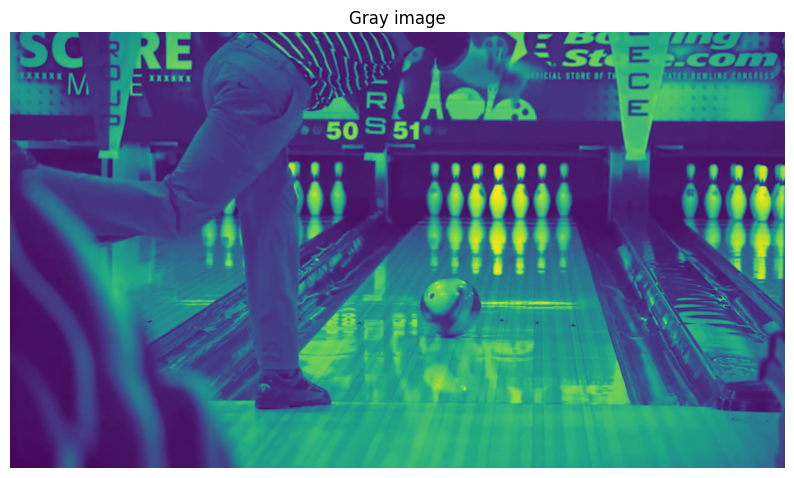

In [5]:
# Convert to grayscale both frames
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Apply a little bit of Blur
gray = cv2.GaussianBlur(gray, (5, 5), 0)
prev_gray = cv2.GaussianBlur(prev_gray, (5, 5), 0)

showImage(gray, "Gray image")

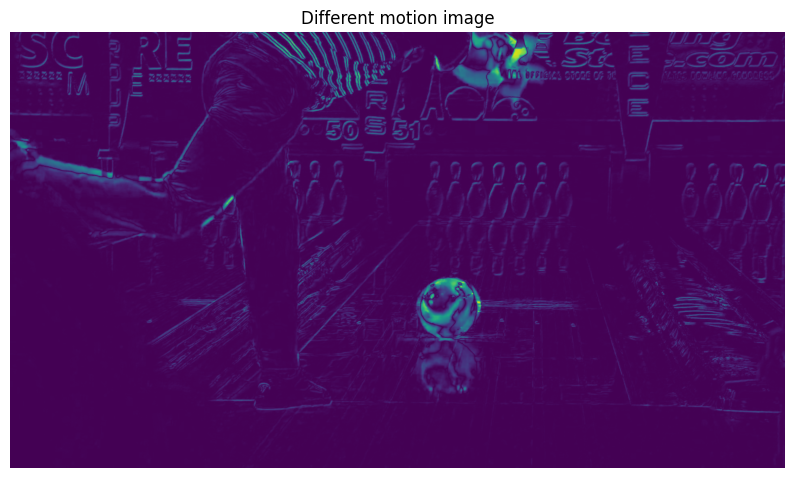

In [6]:
# Compute frame difference with smoothed background
background = prev_gray.copy().astype("float")
bg_diff = cv2.absdiff(gray, cv2.convertScaleAbs(background))

showImage(bg_diff, "Different motion image")

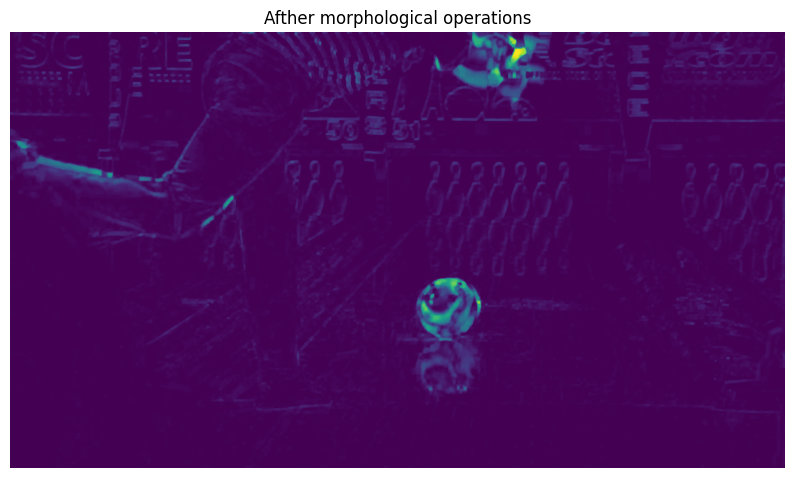

In [7]:
# Morphological operations to reduce noise
kernel = np.ones((5, 5), np.uint8)
thresh = cv2.morphologyEx(bg_diff, cv2.MORPH_OPEN, kernel)  # Remove small noise
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)  # Fill gaps

showImage(thresh, "Afther morphological operations")

In [10]:
cap.release()

## Procesing

Use of pure Hough circle detection

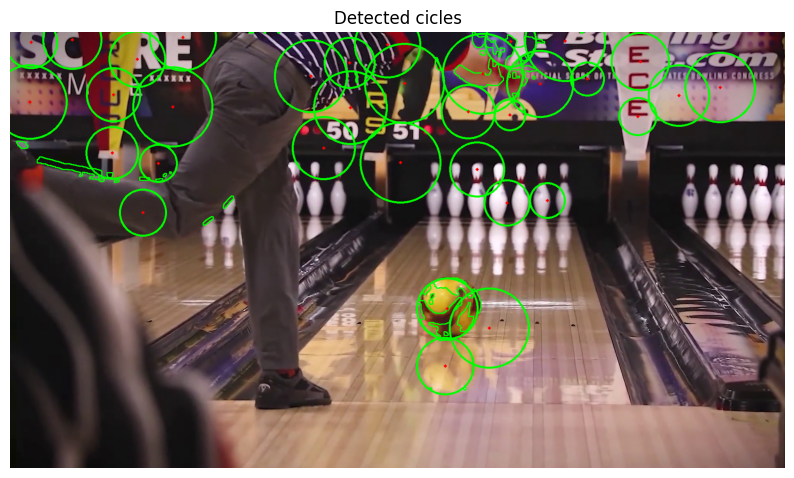

In [11]:
# Hough Circle Detection
circles = cv2.HoughCircles(
    thresh, 
    cv2.HOUGH_GRADIENT, 
    dp=1.2,  # Inverse ratio of resolution
    minDist=100,  # Minimum distance between detected centers
    param1=50,  # Higher threshold for Canny edge detector
    param2=20,  # Accumulator threshold for circle detection
    minRadius=30,  # Minimum radius of detected circles
    maxRadius=100   # Maximum radius of detected circles
)

# Draw circles if detected
if circles is not None:
    circles = np.uint16(np.around(circles))
    output = frame.copy()
    for i in circles[0, :]:
        cv2.circle(output, (i[0], i[1]), i[2], (0, 255, 0), 3)  # Draw circle
        cv2.circle(output, (i[0], i[1]), 2, (0, 0, 255), 3)  # Draw center

    output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    showImage(output_rgb, "Detected cicles")
else:
    print("No circles detected")

Here the problem is that all parameters are good in specific situations. It's better if they change during the execution of the video.

Furthermore, if we have videos that are so different, they may not work if static.

Improvements:

- knowing more or less the dimensions of the ball during the video can help modifying the parameters `minRadius` and `maxRadius`.
- add the fact that the coordinates of the center of the ball do not change so much between two consecutive frames.

## Post-procesing

There is no mutch to do here

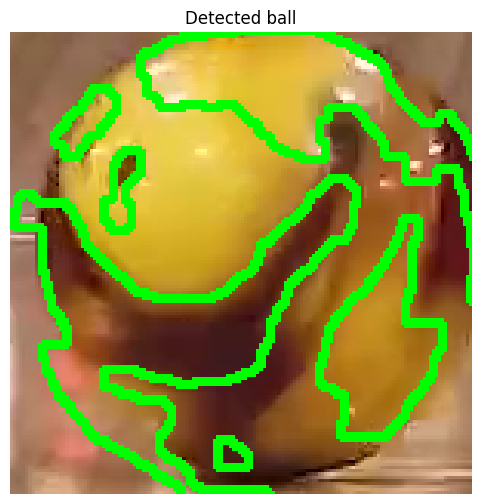

In [12]:
if circles is not None:
    x, y, r = circles[0, 0]  # Get first detected circle
    ball = frame[y-r:y+r, x-r:x+r]  # Crop the ball region
    if ball.size > 0:
        ball_rgb = cv2.cvtColor(ball, cv2.COLOR_BGR2RGB)
        showImage(ball_rgb, "Detected ball")